# Benchmarking models at locating spatial expression of cell types with scRNA-seq reference and Visium spatial (mouse brain)

In [1]:
import sys, ast, os
import time
import pickle
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os
from plotnine import *
import matplotlib.pyplot as plt 
import matplotlib
data_type = 'float32'
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/cell2location/')
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/')

import cell2location.models as c2l
import cell2location.plt as c2lpl
import cell2location.cluster_averages 
import pycell2location

from matplotlib import rcParams
import seaborn as sns
import itertools
import scipy

# scanpy prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

/nfs/users/nfs_v/vk7/.local/lib/python3.7/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
Using cuDNN version 7605 on context None
Mapped name None to device cuda0: Tesla V100-SXM2-32GB (0000:62:00.0)


In [2]:
import rpy2;
from rpy2 import robjects; robjects.r("version")

R object with classes: ('simple.list',) mapped to:
[StrSexpVe..., StrSexpVe..., StrSexpVe..., StrSexpVe..., ..., StrSexpVe..., StrSexpVe..., StrSexpVe..., StrSexpVe...]
  platform: <class 'rpy2.robjects.vectors.StrVector'>
  R object with classes: ('character',) mapped to:
['x86_64-conda_cos6-linux-gnu']
  arch: <class 'rpy2.robjects.vectors.StrVector'>
  R object with classes: ('character',) mapped to:
['x86_64']
  os: <class 'rpy2.robjects.vectors.StrVector'>
  R object with classes: ('character',) mapped to:
['linux-gnu']
  system: <class 'rpy2.robjects.vectors.StrVector'>
  R object with classes: ('character',) mapped to:
['x86_64, linux-gnu']
...
  major: <class 'rpy2.robjects.vectors.StrVector'>
  R object with classes: ('character',) mapped to:
['77875']
  minor: <class 'rpy2.robjects.vectors.StrVector'>
  R object with classes: ('character',) mapped to:
['R']
  year: <class 'rpy2.robjects.vectors.StrVector'>
  R object with classes: ('character',) mapped to:
['R version 3.6.3 (2020-02-29)']
  month: <class 'rpy2.robjects.vectors.StrVector'>
  R object with classes: ('character',) mapped to:
['Holding the Windsock']

In [3]:
from rpy2.robjects.packages import importr
#reticulate = importr('reticulate')
#reticulate.use_condaenv(condaenv = 'cellpymcr', conda = "auto", required = False)
seurat = importr('Seurat')
print(seurat)

R[write to console]: No non-system installation of Python could be found.
Would you like to download and install Miniconda?
Miniconda is an open source environment management system for Python.
See https://docs.conda.io/en/latest/miniconda.html for more details.




Would you like to install Miniconda? [Y/n]: n
rpy2.robjects.packages.Package as a <module 'Seurat'>


In [4]:
%load_ext rpy2.ipython

In [5]:
%%R
library(Seurat)

### The purpose of the notebook is to benchmark several versions of the model using mouse brain data.

## Load input data 

First we load sample annotations.

In [6]:
sp_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/lowdens_synthetic_ST_fewcells/samples_2_v2/'
results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/lowdens_synthetic_ST_fewcells/samples_2/'

seed_numbers = ['335', '604', '10']
seed_numbers = seed_numbers[2]

# load simulated spatial data desing
design = pd.read_csv(sp_data_folder + 'synthetic_ST_seed'+seed_numbers+'_design.csv',
                    index_col=0)
design.index = ['ref_' + i for i in design.index]

# read anndata with sampled gene_levels
downsampled_suff = '8'
adata = anndata.read(f'{sp_data_folder}synthetic_ST_seed{seed_numbers}_counts_downsampled{downsampled_suff}.h5ad')
adata.obs.columns = ['ref_' + i for i in adata.obs.columns]
adata.X = scipy.sparse.csr_matrix(adata.X)
sc.pp.calculate_qc_metrics(adata, inplace=True) 
slides = {'seed'+seed_numbers: adata}
adata_0 = adata.copy()

# load single cell reference used for simulation (validation set)
counts_validation = pickle.load(open(sp_data_folder + 'counts_validation_'+seed_numbers+'.p', 'rb'))
labels_validation = pickle.load(open(sp_data_folder + 'labels_validation_'+seed_numbers+'.p', 'rb'))
adata_snrna_raw = anndata.AnnData(counts_validation, obs=labels_validation)
adata_snrna_raw.X = scipy.sparse.csr_matrix(adata_snrna_raw.X)

design, adata_snrna_raw

(                 uniform  density  nspots  mean_ncells
 ref_Astro_3            0      1.0   160.0     1.047457
 ref_Ext_L25            0      1.0   179.0     2.132758
 ref_Ext_L6             0      1.0   197.0     1.123235
 ref_Oligo_2            0      1.0   180.0     0.059803
 ref_Ext_Hpc_1          0      1.0   145.0     1.165331
 ref_Inh_Meis2_4        0      1.0   224.0     0.899732
 ref_Nb_2               0      0.0   182.0     1.725271
 ref_Ext_L23            0      0.0   184.0     2.634801
 ref_Inh_Pvalb          1      1.0  1729.0     1.344651
 ref_Inh_Vip            0      1.0   218.0     0.243348
 ref_Ext_L5_1           0      0.0   237.0     3.911688
 ref_Inh_4              0      1.0   239.0     0.770593
 ref_Ext_Thal_1         0      1.0   243.0     0.328724
 ref_Inh_Meis2_3        1      0.0  1480.0     3.129082
 ref_Ext_Hpc_2          0      1.0   170.0     1.953083
 ref_Inh_6              0      1.0   226.0     1.563946
 ref_Inh_3              0      0.0   226.0     2

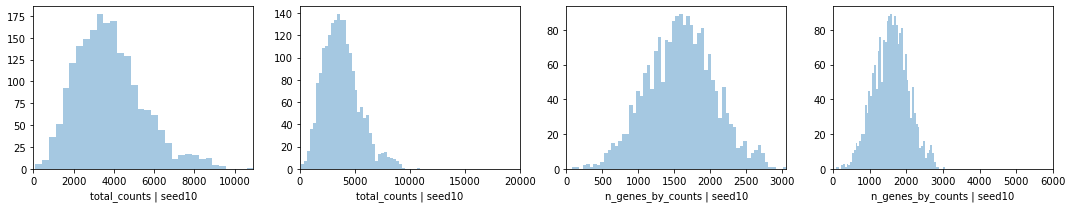

In [7]:
# PLOT QC FOR EACH SAMPLE 
if len(slides) > 2:
    figsize = 4*len(slides)-4
else:
    figsize = 4*len(slides)-1
    
fig, axs = plt.subplots(len(slides), 4, figsize=(15, figsize))
axs = axs.reshape((len(slides), 4))
for i in range(len(slides)):
    #fig.suptitle('Covariates for filtering')
    
    sns.distplot(list(slides.values())[i].obs['total_counts'], 
                 kde=False, ax = axs[i, 0])
    axs[i, 0].set_xlim(0, adata.obs['total_counts'].max())
    axs[i, 0].set_xlabel('total_counts | ' + list(slides.keys())[i])
    
    sns.distplot(list(slides.values())[i].obs['total_counts']\
                 [list(slides.values())[i].obs['total_counts']<20000],
                 kde=False, bins=40, ax = axs[i, 1])
    axs[i, 1].set_xlim(0, 20000)
    axs[i, 1].set_xlabel('total_counts | ' + list(slides.keys())[i])
    
    sns.distplot(list(slides.values())[i].obs['n_genes_by_counts'],
                 kde=False, bins=60, ax = axs[i, 2])
    axs[i, 2].set_xlim(0, adata.obs['n_genes_by_counts'].max())
    axs[i, 2].set_xlabel('n_genes_by_counts | ' + list(slides.keys())[i])
    
    sns.distplot(list(slides.values())[i].obs['n_genes_by_counts']\
                 [list(slides.values())[i].obs['n_genes_by_counts']<6000],
                 kde=False, bins=60, ax = axs[i, 3])
    axs[i, 3].set_xlim(0, 6000)
    axs[i, 3].set_xlabel('n_genes_by_counts | ' + list(slides.keys())[i])
    
plt.tight_layout()

Add counts matrix as `adata.raw` 

In [8]:
# Select genes expressed by at least 2% of cells in each cluster.
adata_snrna_raw_bin = adata_snrna_raw.copy()
adata_snrna_raw_bin.X = adata_snrna_raw_bin.X > 0
adata_snrna_raw_bin.raw = adata_snrna_raw_bin
prop_expressed = cell2location.cluster_averages.cluster_averages.get_cluster_averages(adata_snrna_raw_bin, 'annotation_1')
prop_expressed = prop_expressed.loc[adata_snrna_raw.var_names,:]
adata_snrna_raw = adata_snrna_raw[:, prop_expressed.max(1) > 0.02]

In [9]:
adata_vis = adata.copy()
adata_snrna_raw.raw = adata_snrna_raw
adata_vis.raw = adata_vis

adata_vis.var['ENSEMBL'] = adata_vis.var_names
adata_vis.obs['sample'] = seed_numbers

from re import sub
adata_snrna_raw.obs['sample'] = [sub('_.+$','', i) for i in adata_snrna_raw.obs.index]

#### Plot numbers of cells per spot

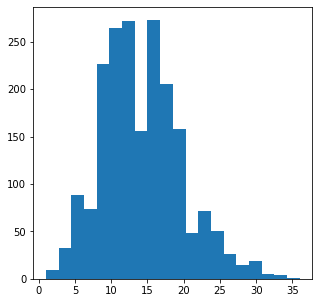

In [10]:
rcParams['figure.figsize'] = 5, 5
cell_count = adata.obs.loc[:, [('ref_' in i) & ('nUMI' not in i)
                               for i in adata.obs.columns]]
plt.hist(cell_count.sum(1), bins=20);

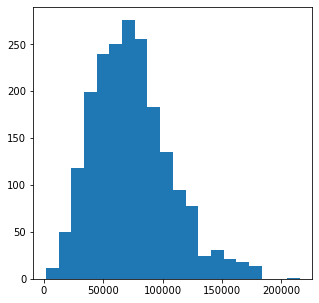

In [11]:
umi_count = adata.obs.loc[:, [('ref_' in i) & ('nUMI' in i)
                               for i in adata.obs.columns]]
plt.hist(umi_count.sum(1), bins=20);

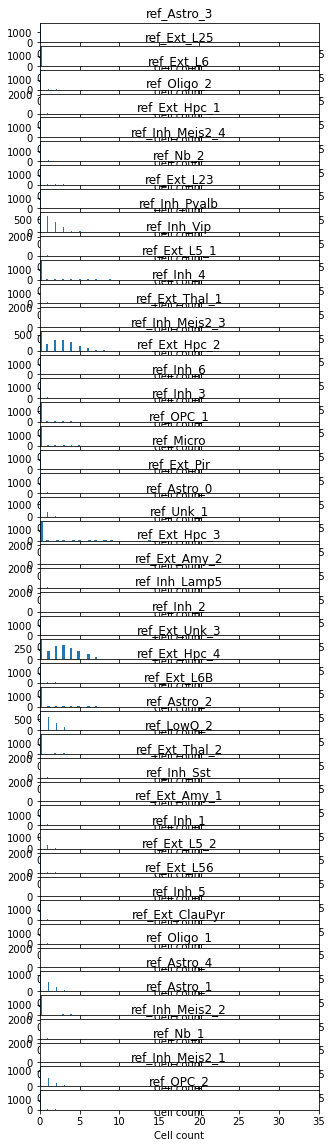

In [12]:
rcParams['figure.figsize'] = 5, 20
for i, c in enumerate(cell_count.columns):
    plt.subplot(cell_count.shape[1], 1, i+1)
    plt.hist(cell_count[c], bins = 35);
    plt.xlabel('Cell count');
    plt.xlim(0, 35);
    plt.title(str(c));
plt.tight_layout()

## Perform nnls

gen	nevals	pareto	correlation    	distance           
0  	100   	1     	983.49 - 983.49	441797.5 - 441797.5
1  	100   	1     	983.49 - 983.49	441797.5 - 441797.5


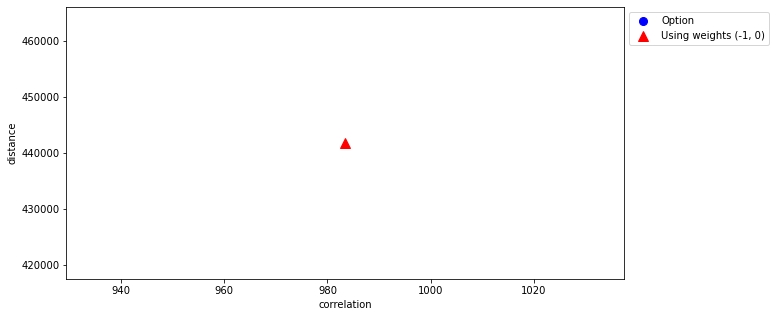

0.367708428700765 min
0.021549677848815917 min


In [13]:
import autogenes as ag

# Select all genes - just use the regression models
adata_snrna_raw.var['selected'] = True

# Initialise autogenes object
#ag.init(adata_snrna_raw, genes_key='selected', celltype_key='annotation_1')
averages = cell2location.cluster_averages.get_cluster_averages(adata_snrna_raw, 'annotation_1')
ag.init(averages.T)
# do not run the gene selection
ag.optimize(ngen=1,nfeatures=averages.shape[0],seed=0,mode='fixed')
ag.plot(weights=(-1,0))

# Deconvolve spatial data into single cell averages
start = time.time()
coef_nnls = ag.deconvolve(adata_vis.raw[:, averages.index].X.toarray(), #key='selected',
                          model='nnls')
print(str((time.time() - start) / 60) + ' min')

start = time.time()
coef_linear = ag.deconvolve(adata_vis.raw[:, averages.index].X.toarray(), #key='selected',
                            model='linear')
print(str((time.time() - start) / 60) + ' min')

#start = time.time()
#coef_nusvr = ag.deconvolve(adata_vis.raw.X.toarray(), #key='selected',
#                           model='nusvr')
#str((time.time() - start) / 60) + ' min'

# save results to DF
coef_nnls_df = pd.DataFrame(coef_nnls.T, columns=adata_vis.obs_names, index=averages.columns)
#coef_nusvr_df = pd.DataFrame(coef_nusvr, columns=adata_vis.obs_names, index=averages.columns)
coef_linear_df = pd.DataFrame(coef_linear.T, columns=adata_vis.obs_names, index=averages.columns)

# write to disc
coef_nnls_df.to_csv(results_folder + f'autogenes_models/downsampled{downsampled_suff}_coef_nnls_seed' + seed_numbers + '.csv')
#coef_nusvr_df.to_csv(results_folder + 'autogenes_models/coef_nusvr_seed' + seed_numbers + '.csv')
coef_linear_df.to_csv(results_folder + f'autogenes_models/downsampled{downsampled_suff}_coef_linear_seed' + seed_numbers + '.csv')

### Move single cell and spatial data to R

In [14]:
adata_snrna_raw_X = adata_snrna_raw.raw.X.toarray()
adata_snrna_raw_obs = adata_snrna_raw.obs
adata_snrna_raw_var_names = adata_snrna_raw.raw.var_names

adata_vis_X = adata_vis.raw.X.toarray()
adata_vis_obs = adata_vis.obs
adata_vis_var_names = adata_vis.raw.var_names

In [15]:
%R -i adata_snrna_raw_X
%R -i adata_snrna_raw_obs
%R -i adata_snrna_raw_var_names

%R -i adata_vis_X
%R -i adata_vis_obs
%R -i adata_vis_var_names

In [16]:
%%R
# Initialize the Seurat object with the raw (non-normalized data).
colnames(adata_snrna_raw_X) = adata_snrna_raw_var_names
rownames(adata_snrna_raw_X) = rownames(adata_snrna_raw_obs)

seu_snrna_raw_X <- CreateSeuratObject(counts = t(adata_snrna_raw_X), 
                                      project = "snRNA-seq",
                                      meta.data = adata_snrna_raw_obs)

Seurat::Idents(object = seu_snrna_raw_X) <- seu_snrna_raw_X@meta.data$annotation_1
seu_snrna_raw_X[["RNA"]]@meta.features <- data.frame(row.names = rownames(seu_snrna_raw_X[["RNA"]]), 
                                                     ENSEMBL = rownames(seu_snrna_raw_X[["RNA"]]))

seu_snrna_raw_X

An object of class Seurat 
19605 features across 8137 samples within 1 assay 
Active assay: RNA (19605 features, 0 variable features)


In [17]:
%%R
# Initialize the Seurat object with the raw (non-normalized data).
colnames(adata_vis_X) = adata_vis_var_names
rownames(adata_vis_X) = rownames(adata_vis_obs)

seu_vis_X <- CreateSeuratObject(counts = t(adata_vis_X), 
                                project = "snRNA-seq",
                                meta.data = adata_vis_obs)

Seurat::Idents(object = seu_vis_X) <- seu_vis_X@meta.data$orig.ident
seu_vis_X[["RNA"]]@meta.features <- data.frame(row.names = rownames(seu_vis_X[["RNA"]]), 
                                               ENSEMBL = rownames(seu_vis_X[["RNA"]]))

seu_vis_X

An object of class Seurat 
31053 features across 2000 samples within 1 assay 
Active assay: RNA (31053 features, 0 variable features)


### Pre-process single cell and spatial data with Seurat and do label transfer

Using the PCA approach

In [18]:
seu_file = results_folder + f'seurat/dowsampled{downsampled_suff}_seurat_pca_seed' + seed_numbers + '.csv'

In [19]:
%%R -i seu_file
library(dplyr)

seu_snrna_raw_X <- SCTransform(seu_snrna_raw_X, verbose = FALSE) %>% RunPCA(verbose = FALSE)
seu_vis_X <- SCTransform(seu_vis_X, verbose = FALSE) %>% RunPCA(verbose = FALSE)

start_time <- Sys.time()

anchors <- FindTransferAnchors(reference = seu_snrna_raw_X, query = seu_vis_X, normalization.method = "SCT")

predictions.assay <- TransferData(anchorset = anchors, refdata = seu_snrna_raw_X$annotation_1,
                                  weight.reduction = seu_vis_X[["pca"]])

#seu_vis_X[["predictions"]] <- predictions.assay

saveRDS(object = predictions.assay,
        file = "./seurat_on_simulated_downsampled.RDS")

predictions.assay$spot = rownames(predictions.assay)
write.csv(predictions.assay, seu_file)
predictions.assay[1:5, 1:5]

end_time <- Sys.time()
end_time - start_time

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: Performing PCA on the provided reference using 1975 features as input.

R[write to console]: Projecting PCA

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 2148 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 1983 anchors

R[write to console]: Extracting within-dataset neighbors

R[write to console]: Finding integration vectors

R[write to console]: Finding integration vector weights

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to c

Time difference of 25.14326 secs


Using the CCA approach

In [20]:
seu_file = results_folder + f'seurat/dowsampled{downsampled_suff}_seurat_cca_seed' + seed_numbers + '.csv'

In [21]:
%%R -i seu_file
library(dplyr)
start_time <- Sys.time()
anchors <- FindTransferAnchors(reference = seu_snrna_raw_X, query = seu_vis_X, 
                               normalization.method = "SCT", reduction='cca')

predictions.assay <- TransferData(anchorset = anchors, refdata = seu_snrna_raw_X$annotation_1,
                                  weight.reduction = 'cca')

#seu_vis_X[["predictions"]] <- predictions.assay

saveRDS(object = predictions.assay,
        file = "./seurat_cca_on_simulated.RDS")

predictions.assay$spot = rownames(predictions.assay)
write.csv(predictions.assay, seu_file)
predictions.assay[1:5, 1:5]

end_time <- Sys.time()
end_time - start_time

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 5066 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 4240 anchors

R[write to console]: Extracting within-dataset neighbors

R[write to console]: Finding integration vectors

R[write to console]: Finding integration vector weights

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to c

Time difference of 31.45708 secs


In [ ]:
%%R
?FindTransferAnchors

### Run SPOTlight

In [27]:
%%R
start_time <- Sys.time()

#### Extract the top marker genes from each cluster ####
Seurat::Idents(object = seu_snrna_raw_X) <- seu_snrna_raw_X@meta.data$annotation_1
cluster_markers_all <- Seurat::FindAllMarkers(object = seu_snrna_raw_X, 
                                              assay = "RNA",
                                              slot = "data",
                                              verbose = TRUE, 
                                              only.pos = TRUE, 
                                              logfc.threshold = 1,
                                              min.pct = 0.9)

library(SPOTlight)
library(Seurat)
library(dplyr)

set.seed(123)
spotlight_ls <- spotlight_deconvolution(se_sc = seu_snrna_raw_X,
                                      counts_spatial = seu_vis_X@assays$RNA@counts,
                                      clust_vr = "annotation_1",
                                      cluster_markers = cluster_markers_all,
                                      cl_n = 100, # 100 by default
                                      hvg = 5000,
                                      ntop = NULL,
                                      transf = "uv",
                                      method = "nsNMF",
                                      min_cont = 0.09)

saveRDS(object = spotlight_ls,
        file = "./dowsampled_spotlight_on_simulated.RDS")

end_time <- Sys.time()
end_time - start_time

R[write to console]: Calculating cluster Inh_4



  |                                                  | 0 % ~calculating   |+++++                                             | 9 % ~00s           |++++++++++                                        | 18% ~00s           |++++++++++++++                                    | 27% ~00s           |+++++++++++++++++++                               | 36% ~00s           |+++++++++++++++++++++++                           | 45% ~00s           |++++++++++++++++++++++++++++                      | 55% ~00s           |++++++++++++++++++++++++++++++++                  | 64% ~00s           |+++++++++++++++++++++++++++++++++++++             | 73% ~00s           |+++++++++++++++++++++++++++++++++++++++++         | 82% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++    | 91% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=00s  


R[write to console]: Calculating cluster Oligo_2



  |                                                  | 0 % ~calculating   |++++++++                                          | 14% ~00s           |+++++++++++++++                                   | 29% ~00s           |++++++++++++++++++++++                            | 43% ~00s           |+++++++++++++++++++++++++++++                     | 57% ~00s           |++++++++++++++++++++++++++++++++++++              | 71% ~00s           |+++++++++++++++++++++++++++++++++++++++++++       | 86% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=00s  


R[write to console]: Calculating cluster Ext_Hpc_4



  |                                                  | 0 % ~calculating   |+++++                                             | 9 % ~00s           |++++++++++                                        | 18% ~00s           |++++++++++++++                                    | 27% ~00s           |+++++++++++++++++++                               | 36% ~00s           |+++++++++++++++++++++++                           | 45% ~00s           |++++++++++++++++++++++++++++                      | 55% ~00s           |++++++++++++++++++++++++++++++++                  | 64% ~00s           |+++++++++++++++++++++++++++++++++++++             | 73% ~00s           |+++++++++++++++++++++++++++++++++++++++++         | 82% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++    | 91% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=00s  


R[write to console]: Calculating cluster Ext_Unk_3



  |                                                  | 0 % ~calculating   |++                                                | 2 % ~01s           |+++                                               | 4 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 17% ~01s           |++++++++++                                        | 20% ~01s           |+++++++++++                                       | 22% ~01s           |++++++++++++                                      | 24% ~01s           |++++++++++++++                                    | 26% ~01s           |+++++++++++++++                                   | 28% ~01s 

R[write to console]: Calculating cluster OPC_1



  |                                                  | 0 % ~calculating   |+++++++++++++                                     | 25% ~00s           |+++++++++++++++++++++++++                         | 50% ~00s           |++++++++++++++++++++++++++++++++++++++            | 75% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=00s  


R[write to console]: Calculating cluster Inh_1



  |                                                  | 0 % ~calculating   |+++++++++++++++++                                 | 33% ~00s           |++++++++++++++++++++++++++++++++++                | 67% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=00s  


R[write to console]: Calculating cluster Ext_Pir



  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 8 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 16% ~01s           |++++++++++                                        | 18% ~01s           |++++++++++                                        | 20% ~01s           |+++++++++++                                       | 21% ~01s 

R[write to console]: Calculating cluster Ext_ClauPyr



  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 6 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 14% ~01s           |++++++++                                          | 16% ~01s           |+++++++++                                         | 18% ~01s           |++++++++++                                        | 20% ~01s           |+++++++++++                                       | 22% ~01s           |++++++++++++                                      | 24% ~01s           |+++++++++++++                                     | 25% ~01s 

R[write to console]: Calculating cluster LowQ_2



  |                                                  | 0 % ~calculating   |++++++                                            | 11% ~00s           |++++++++++++                                      | 22% ~00s           |+++++++++++++++++                                 | 33% ~00s           |+++++++++++++++++++++++                           | 44% ~00s           |++++++++++++++++++++++++++++                      | 56% ~00s           |++++++++++++++++++++++++++++++++++                | 67% ~00s           |+++++++++++++++++++++++++++++++++++++++           | 78% ~00s           |+++++++++++++++++++++++++++++++++++++++++++++     | 89% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=00s  


R[write to console]: Calculating cluster Ext_Amy_2



  |                                                  | 0 % ~calculating   |++                                                | 2 % ~01s           |+++                                               | 4 % ~01s           |++++                                              | 6 % ~01s           |+++++                                             | 8 % ~01s           |++++++                                            | 10% ~01s           |+++++++                                           | 12% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 17% ~01s           |++++++++++                                        | 19% ~01s           |+++++++++++                                       | 21% ~01s           |++++++++++++                                      | 23% ~01s           |+++++++++++++                                     | 25% ~01s           |++++++++++++++                                    | 27% ~01s 

R[write to console]: Calculating cluster Micro



  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=00s  


R[write to console]: Calculating cluster Ext_L23



  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 8 % ~01s           |++++++                                            | 10% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 14% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 17% ~01s           |++++++++++                                        | 19% ~01s           |+++++++++++                                       | 20% ~01s           |++++++++++++                                      | 22% ~01s 

R[write to console]: Calculating cluster Inh_Pvalb



  |                                                  | 0 % ~calculating   |++                                                | 3 % ~00s           |++++                                              | 7 % ~00s           |+++++                                             | 10% ~00s           |+++++++                                           | 13% ~00s           |+++++++++                                         | 17% ~00s           |++++++++++                                        | 20% ~00s           |++++++++++++                                      | 23% ~00s           |++++++++++++++                                    | 27% ~00s           |+++++++++++++++                                   | 30% ~00s           |+++++++++++++++++                                 | 33% ~00s           |+++++++++++++++++++                               | 37% ~00s           |++++++++++++++++++++                              | 40% ~00s           |++++++++++++++++++++++                            | 43% ~00s 

R[write to console]: Calculating cluster Inh_5



  |                                                  | 0 % ~calculating   |+++                                               | 6 % ~00s           |++++++                                            | 11% ~00s           |+++++++++                                         | 17% ~00s           |++++++++++++                                      | 22% ~00s           |++++++++++++++                                    | 28% ~00s           |+++++++++++++++++                                 | 33% ~00s           |++++++++++++++++++++                              | 39% ~00s           |+++++++++++++++++++++++                           | 44% ~00s           |+++++++++++++++++++++++++                         | 50% ~00s           |++++++++++++++++++++++++++++                      | 56% ~00s           |+++++++++++++++++++++++++++++++                   | 61% ~00s           |++++++++++++++++++++++++++++++++++                | 67% ~00s           |+++++++++++++++++++++++++++++++++++++             | 72% ~00s 

R[write to console]: Calculating cluster Inh_Sst



  |                                                  | 0 % ~calculating   |++++++++                                          | 14% ~00s           |+++++++++++++++                                   | 29% ~00s           |++++++++++++++++++++++                            | 43% ~00s           |+++++++++++++++++++++++++++++                     | 57% ~00s           |++++++++++++++++++++++++++++++++++++              | 71% ~00s           |+++++++++++++++++++++++++++++++++++++++++++       | 86% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=00s  


R[write to console]: Calculating cluster Ext_Thal_1



  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~03s           |++                                                | 2 % ~03s           |++                                                | 3 % ~03s           |+++                                               | 5 % ~03s           |+++                                               | 6 % ~03s           |++++                                              | 7 % ~03s           |+++++                                             | 8 % ~03s           |+++++                                             | 9 % ~03s           |++++++                                            | 10% ~02s           |++++++                                            | 11% ~02s           |+++++++                                           | 13% ~02s           |+++++++                                           | 14% ~02s           |++++++++                                          | 15% ~02s 

R[write to console]: Calculating cluster Ext_L25



  |                                                  | 0 % ~calculating   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=00s  


R[write to console]: Calculating cluster OPC_2



  |                                                  | 0 % ~calculating   |+++++                                             | 8 % ~00s           |+++++++++                                         | 17% ~00s           |+++++++++++++                                     | 25% ~00s           |+++++++++++++++++                                 | 33% ~00s           |+++++++++++++++++++++                             | 42% ~00s           |+++++++++++++++++++++++++                         | 50% ~00s           |++++++++++++++++++++++++++++++                    | 58% ~00s           |++++++++++++++++++++++++++++++++++                | 67% ~00s           |++++++++++++++++++++++++++++++++++++++            | 75% ~00s           |++++++++++++++++++++++++++++++++++++++++++        | 83% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++    | 92% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=00s  


R[write to console]: Calculating cluster Ext_Hpc_1



  |                                                  | 0 % ~calculating   |++                                                | 2 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 10% ~01s           |+++++++                                           | 12% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 18% ~01s           |++++++++++                                        | 20% ~01s           |++++++++++++                                      | 22% ~01s           |+++++++++++++                                     | 25% ~00s           |++++++++++++++                                    | 28% ~00s           |+++++++++++++++                                   | 30% ~00s           |+++++++++++++++++                                 | 32% ~00s 

R[write to console]: Calculating cluster Inh_Meis2_2



  |                                                  | 0 % ~calculating   |+++                                               | 6 % ~00s           |++++++                                            | 11% ~00s           |+++++++++                                         | 17% ~00s           |++++++++++++                                      | 22% ~00s           |++++++++++++++                                    | 28% ~00s           |+++++++++++++++++                                 | 33% ~00s           |++++++++++++++++++++                              | 39% ~00s           |+++++++++++++++++++++++                           | 44% ~00s           |+++++++++++++++++++++++++                         | 50% ~00s           |++++++++++++++++++++++++++++                      | 56% ~00s           |+++++++++++++++++++++++++++++++                   | 61% ~00s           |++++++++++++++++++++++++++++++++++                | 67% ~00s           |+++++++++++++++++++++++++++++++++++++             | 72% ~00s 

R[write to console]: Calculating cluster Astro_0



  |                                                  | 0 % ~calculating   |++++++++++                                        | 20% ~00s           |++++++++++++++++++++                              | 40% ~00s           |++++++++++++++++++++++++++++++                    | 60% ~00s           |++++++++++++++++++++++++++++++++++++++++          | 80% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=00s  


R[write to console]: Calculating cluster Inh_6



  |                                                  | 0 % ~calculating   |++++                                              | 7 % ~00s           |+++++++                                           | 13% ~00s           |++++++++++                                        | 20% ~00s           |++++++++++++++                                    | 27% ~00s           |+++++++++++++++++                                 | 33% ~00s           |++++++++++++++++++++                              | 40% ~00s           |++++++++++++++++++++++++                          | 47% ~00s           |+++++++++++++++++++++++++++                       | 53% ~00s           |++++++++++++++++++++++++++++++                    | 60% ~00s           |++++++++++++++++++++++++++++++++++                | 67% ~00s           |+++++++++++++++++++++++++++++++++++++             | 73% ~00s           |++++++++++++++++++++++++++++++++++++++++          | 80% ~00s           |++++++++++++++++++++++++++++++++++++++++++++      | 87% ~00s 

R[write to console]: Calculating cluster Unk_1

R[write to console]: Calculating cluster Ext_L5_2



  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~02s           |++                                                | 3 % ~02s           |++                                                | 4 % ~02s           |+++                                               | 5 % ~02s           |++++                                              | 7 % ~02s           |++++                                              | 8 % ~02s           |+++++                                             | 9 % ~02s           |++++++                                            | 11% ~02s           |++++++                                            | 12% ~02s           |+++++++                                           | 13% ~02s           |++++++++                                          | 15% ~02s           |++++++++                                          | 16% ~02s           |+++++++++                                         | 17% ~02s 

R[write to console]: Calculating cluster Ext_L5_1



  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 6 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 17% ~01s           |++++++++++                                        | 19% ~01s           |+++++++++++                                       | 21% ~01s           |++++++++++++                                      | 23% ~01s           |+++++++++++++                                     | 25% ~01s 

R[write to console]: Calculating cluster Ext_L56



  |                                                  | 0 % ~calculating   |++++                                              | 6 % ~00s           |+++++++                                           | 12% ~00s           |++++++++++                                        | 19% ~00s           |+++++++++++++                                     | 25% ~00s           |++++++++++++++++                                  | 31% ~00s           |+++++++++++++++++++                               | 38% ~00s           |++++++++++++++++++++++                            | 44% ~00s           |+++++++++++++++++++++++++                         | 50% ~00s           |+++++++++++++++++++++++++++++                     | 56% ~00s           |++++++++++++++++++++++++++++++++                  | 62% ~00s           |+++++++++++++++++++++++++++++++++++               | 69% ~00s           |++++++++++++++++++++++++++++++++++++++            | 75% ~00s           |+++++++++++++++++++++++++++++++++++++++++         | 81% ~00s 

R[write to console]: Calculating cluster Astro_2



  |                                                  | 0 % ~calculating   |+++                                               | 5 % ~00s           |+++++                                             | 10% ~00s           |++++++++                                          | 14% ~00s           |++++++++++                                        | 19% ~00s           |++++++++++++                                      | 24% ~00s           |+++++++++++++++                                   | 29% ~00s           |+++++++++++++++++                                 | 33% ~00s           |++++++++++++++++++++                              | 38% ~00s           |++++++++++++++++++++++                            | 43% ~00s           |++++++++++++++++++++++++                          | 48% ~00s           |+++++++++++++++++++++++++++                       | 52% ~00s           |+++++++++++++++++++++++++++++                     | 57% ~00s           |+++++++++++++++++++++++++++++++                   | 62% ~00s 

R[write to console]: Calculating cluster Inh_Meis2_1



  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=00s  


R[write to console]: Calculating cluster Ext_Hpc_2



  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~02s           |++                                                | 3 % ~02s           |+++                                               | 4 % ~02s           |+++                                               | 6 % ~02s           |++++                                              | 7 % ~02s           |+++++                                             | 9 % ~02s           |++++++                                            | 10% ~02s           |++++++                                            | 12% ~02s           |+++++++                                           | 13% ~02s           |++++++++                                          | 14% ~02s           |++++++++                                          | 16% ~02s           |+++++++++                                         | 17% ~02s           |++++++++++                                        | 19% ~02s 

R[write to console]: Calculating cluster Ext_L6



  |                                                  | 0 % ~calculating   |++                                                | 3 % ~01s           |++++                                              | 7 % ~00s           |++++++                                            | 10% ~00s           |+++++++                                           | 14% ~00s           |+++++++++                                         | 17% ~00s           |+++++++++++                                       | 21% ~00s           |+++++++++++++                                     | 24% ~00s           |++++++++++++++                                    | 28% ~00s           |++++++++++++++++                                  | 31% ~00s           |++++++++++++++++++                                | 34% ~00s           |+++++++++++++++++++                               | 38% ~00s           |+++++++++++++++++++++                             | 41% ~00s           |+++++++++++++++++++++++                           | 45% ~00s 

R[write to console]: Calculating cluster Oligo_1



  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 12% ~01s           |++++++++                                          | 14% ~01s           |+++++++++                                         | 16% ~01s           |+++++++++                                         | 18% ~01s           |++++++++++                                        | 20% ~01s           |+++++++++++                                       | 21% ~01s           |++++++++++++                                      | 23% ~01s 

R[write to console]: Calculating cluster Ext_Amy_1



  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 6 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 17% ~01s           |++++++++++                                        | 19% ~01s           |+++++++++++                                       | 20% ~01s           |++++++++++++                                      | 22% ~01s           |+++++++++++++                                     | 24% ~01s 

R[write to console]: Calculating cluster Inh_Lamp5



  |                                                  | 0 % ~calculating   |++++                                              | 8 % ~00s           |++++++++                                          | 15% ~00s           |++++++++++++                                      | 23% ~00s           |++++++++++++++++                                  | 31% ~00s           |++++++++++++++++++++                              | 38% ~00s           |++++++++++++++++++++++++                          | 46% ~00s           |+++++++++++++++++++++++++++                       | 54% ~00s           |+++++++++++++++++++++++++++++++                   | 62% ~00s           |+++++++++++++++++++++++++++++++++++               | 69% ~00s           |+++++++++++++++++++++++++++++++++++++++           | 77% ~00s           |+++++++++++++++++++++++++++++++++++++++++++       | 85% ~00s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 92% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elap

R[write to console]: Calculating cluster Inh_2



  |                                                  | 0 % ~calculating   |++                                                | 3 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 10% ~00s           |+++++++                                           | 13% ~00s           |+++++++++                                         | 17% ~00s           |++++++++++                                        | 20% ~00s           |++++++++++++                                      | 23% ~00s           |++++++++++++++                                    | 27% ~00s           |+++++++++++++++                                   | 30% ~00s           |+++++++++++++++++                                 | 33% ~00s           |+++++++++++++++++++                               | 37% ~00s           |++++++++++++++++++++                              | 40% ~00s           |++++++++++++++++++++++                            | 43% ~00s 

R[write to console]: Calculating cluster Ext_Thal_2



  |                                                  | 0 % ~calculating   |++                                                | 3 % ~00s           |+++                                               | 6 % ~00s           |+++++                                             | 9 % ~00s           |++++++                                            | 11% ~00s           |++++++++                                          | 14% ~00s           |+++++++++                                         | 17% ~00s           |++++++++++                                        | 20% ~00s           |++++++++++++                                      | 23% ~00s           |+++++++++++++                                     | 26% ~00s           |+++++++++++++++                                   | 29% ~00s           |++++++++++++++++                                  | 31% ~00s           |++++++++++++++++++                                | 34% ~00s           |+++++++++++++++++++                               | 37% ~00s 

R[write to console]: Calculating cluster Astro_1



  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=00s  


R[write to console]: Calculating cluster Inh_Vip



  |                                                  | 0 % ~calculating   |+++++                                             | 10% ~00s           |++++++++++                                        | 20% ~00s           |+++++++++++++++                                   | 30% ~00s           |++++++++++++++++++++                              | 40% ~00s           |+++++++++++++++++++++++++                         | 50% ~00s           |++++++++++++++++++++++++++++++                    | 60% ~00s           |+++++++++++++++++++++++++++++++++++               | 70% ~00s           |++++++++++++++++++++++++++++++++++++++++          | 80% ~00s           |+++++++++++++++++++++++++++++++++++++++++++++     | 90% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=00s  


R[write to console]: Calculating cluster Inh_Meis2_3



  |                                                  | 0 % ~calculating   |+++++                                             | 8 % ~00s           |+++++++++                                         | 17% ~00s           |+++++++++++++                                     | 25% ~00s           |+++++++++++++++++                                 | 33% ~00s           |+++++++++++++++++++++                             | 42% ~00s           |+++++++++++++++++++++++++                         | 50% ~00s           |++++++++++++++++++++++++++++++                    | 58% ~00s           |++++++++++++++++++++++++++++++++++                | 67% ~00s           |++++++++++++++++++++++++++++++++++++++            | 75% ~00s           |++++++++++++++++++++++++++++++++++++++++++        | 83% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++    | 92% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=00s  


R[write to console]: Calculating cluster Inh_3



  |                                                  | 0 % ~calculating   |+++++++++++++                                     | 25% ~00s           |+++++++++++++++++++++++++                         | 50% ~00s           |++++++++++++++++++++++++++++++++++++++            | 75% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=00s  


R[write to console]: Calculating cluster Ext_Hpc_3



  |                                                  | 0 % ~calculating   |++++++++++                                        | 20% ~00s           |++++++++++++++++++++                              | 40% ~00s           |++++++++++++++++++++++++++++++                    | 60% ~00s           |++++++++++++++++++++++++++++++++++++++++          | 80% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=00s  


R[write to console]: Calculating cluster Astro_3



  |                                                  | 0 % ~calculating   |+++++++                                           | 12% ~00s           |+++++++++++++                                     | 25% ~00s           |+++++++++++++++++++                               | 38% ~00s           |+++++++++++++++++++++++++                         | 50% ~00s           |++++++++++++++++++++++++++++++++                  | 62% ~00s           |++++++++++++++++++++++++++++++++++++++            | 75% ~00s           |++++++++++++++++++++++++++++++++++++++++++++      | 88% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=00s  


R[write to console]: Calculating cluster Ext_L6B



  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 4 % ~01s           |+++                                               | 6 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 10% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 16% ~01s           |+++++++++                                         | 18% ~01s           |++++++++++                                        | 19% ~01s 

R[write to console]: Calculating cluster Inh_Meis2_4



  |                                                  | 0 % ~calculating   |++                                                | 3 % ~01s           |++++                                              | 7 % ~00s           |+++++                                             | 10% ~00s           |+++++++                                           | 13% ~00s           |+++++++++                                         | 17% ~00s           |++++++++++                                        | 20% ~00s           |++++++++++++                                      | 23% ~00s           |++++++++++++++                                    | 27% ~00s           |+++++++++++++++                                   | 30% ~00s           |+++++++++++++++++                                 | 33% ~00s           |+++++++++++++++++++                               | 37% ~00s           |++++++++++++++++++++                              | 40% ~00s           |++++++++++++++++++++++                            | 43% ~00s 

R[write to console]: Calculating cluster Nb_2

R[write to console]: Calculating cluster Nb_1

R[write to console]: Calculating cluster Astro_4

R[write to console]: Loading required package: dplyr

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: Calculating gene variances
R[write to console]: 

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to consol

[1] "Preparing Gene set"
[1] "Normalizing count matrix"
[1] "Seeding initial matrices"
[1] "Training..."
[1] "Time to train NMF model was 244.99mins"
[1] "Deconvoluting spots"
  |======================================================================| 100%
Time difference of 4.128453 hours


In [28]:
spotlight_file = results_folder + f'seurat/dowsampled{downsampled_suff}_spotlight_seed' + seed_numbers + '.csv'

In [29]:
%%R -i spotlight_file
decon_mtrx <- spotlight_ls[[2]]
rownames(decon_mtrx) = colnames(seu_vis_X)

library(data.table)
decon_df = as.data.table(decon_mtrx, keep.rownames=TRUE)
fwrite(decon_df, spotlight_file)

R[write to console]: data.table 1.12.8 using 4 threads (see ?getDTthreads).  Latest news: r-datatable.com

R[write to console]: 
Attaching package: ‘data.table’


R[write to console]: The following object is masked from ‘package:purrr’:

    transpose


R[write to console]: The following objects are masked from ‘package:dplyr’:

    between, first, last




Use less HVG

In [30]:
%%R
start_time <- Sys.time()

#### Extract the top marker genes from each cluster ####
Seurat::Idents(object = seu_snrna_raw_X) <- seu_snrna_raw_X@meta.data$annotation_1
cluster_markers_all <- Seurat::FindAllMarkers(object = seu_snrna_raw_X, 
                                              assay = "RNA",
                                              slot = "data",
                                              verbose = TRUE, 
                                              only.pos = TRUE, 
                                              logfc.threshold = 1,
                                              min.pct = 0.9)

library(SPOTlight)
library(Seurat)
library(dplyr)

set.seed(123)
spotlight_ls <- spotlight_deconvolution(se_sc = seu_snrna_raw_X,
                                      counts_spatial = seu_vis_X@assays$RNA@counts,
                                      clust_vr = "annotation_1",
                                      cluster_markers = cluster_markers_all,
                                      cl_n = 100, # 100 by default
                                      hvg = 3000,
                                      ntop = NULL,
                                      transf = "uv",
                                      method = "nsNMF",
                                      min_cont = 0.09)

saveRDS(object = spotlight_ls,
        file = "./dowsampled_spotlight_on_simulated_hvg3k.RDS")

end_time <- Sys.time()
end_time - start_time

R[write to console]: Calculating cluster Inh_4



  |                                                  | 0 % ~calculating   |+++++                                             | 9 % ~00s           |++++++++++                                        | 18% ~00s           |++++++++++++++                                    | 27% ~00s           |+++++++++++++++++++                               | 36% ~00s           |+++++++++++++++++++++++                           | 45% ~00s           |++++++++++++++++++++++++++++                      | 55% ~00s           |++++++++++++++++++++++++++++++++                  | 64% ~00s           |+++++++++++++++++++++++++++++++++++++             | 73% ~00s           |+++++++++++++++++++++++++++++++++++++++++         | 82% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++    | 91% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=00s  


R[write to console]: Calculating cluster Oligo_2



  |                                                  | 0 % ~calculating   |++++++++                                          | 14% ~00s           |+++++++++++++++                                   | 29% ~00s           |++++++++++++++++++++++                            | 43% ~00s           |+++++++++++++++++++++++++++++                     | 57% ~00s           |++++++++++++++++++++++++++++++++++++              | 71% ~00s           |+++++++++++++++++++++++++++++++++++++++++++       | 86% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=00s  


R[write to console]: Calculating cluster Ext_Hpc_4



  |                                                  | 0 % ~calculating   |+++++                                             | 9 % ~00s           |++++++++++                                        | 18% ~00s           |++++++++++++++                                    | 27% ~00s           |+++++++++++++++++++                               | 36% ~00s           |+++++++++++++++++++++++                           | 45% ~00s           |++++++++++++++++++++++++++++                      | 55% ~00s           |++++++++++++++++++++++++++++++++                  | 64% ~00s           |+++++++++++++++++++++++++++++++++++++             | 73% ~00s           |+++++++++++++++++++++++++++++++++++++++++         | 82% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++    | 91% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=00s  


R[write to console]: Calculating cluster Ext_Unk_3



  |                                                  | 0 % ~calculating   |++                                                | 2 % ~01s           |+++                                               | 4 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 17% ~01s           |++++++++++                                        | 20% ~01s           |+++++++++++                                       | 22% ~01s           |++++++++++++                                      | 24% ~01s           |++++++++++++++                                    | 26% ~01s           |+++++++++++++++                                   | 28% ~01s 

R[write to console]: Calculating cluster OPC_1



  |                                                  | 0 % ~calculating   |+++++++++++++                                     | 25% ~00s           |+++++++++++++++++++++++++                         | 50% ~00s           |++++++++++++++++++++++++++++++++++++++            | 75% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=00s  


R[write to console]: Calculating cluster Inh_1



  |                                                  | 0 % ~calculating   |+++++++++++++++++                                 | 33% ~00s           |++++++++++++++++++++++++++++++++++                | 67% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=00s  


R[write to console]: Calculating cluster Ext_Pir



  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 8 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 16% ~01s           |++++++++++                                        | 18% ~01s           |++++++++++                                        | 20% ~01s           |+++++++++++                                       | 21% ~01s 

R[write to console]: Calculating cluster Ext_ClauPyr



  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 6 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 14% ~01s           |++++++++                                          | 16% ~01s           |+++++++++                                         | 18% ~01s           |++++++++++                                        | 20% ~01s           |+++++++++++                                       | 22% ~01s           |++++++++++++                                      | 24% ~01s           |+++++++++++++                                     | 25% ~01s 

R[write to console]: Calculating cluster LowQ_2



  |                                                  | 0 % ~calculating   |++++++                                            | 11% ~00s           |++++++++++++                                      | 22% ~00s           |+++++++++++++++++                                 | 33% ~00s           |+++++++++++++++++++++++                           | 44% ~00s           |++++++++++++++++++++++++++++                      | 56% ~00s           |++++++++++++++++++++++++++++++++++                | 67% ~00s           |+++++++++++++++++++++++++++++++++++++++           | 78% ~00s           |+++++++++++++++++++++++++++++++++++++++++++++     | 89% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=00s  


R[write to console]: Calculating cluster Ext_Amy_2



  |                                                  | 0 % ~calculating   |++                                                | 2 % ~01s           |+++                                               | 4 % ~01s           |++++                                              | 6 % ~01s           |+++++                                             | 8 % ~01s           |++++++                                            | 10% ~01s           |+++++++                                           | 12% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 17% ~01s           |++++++++++                                        | 19% ~01s           |+++++++++++                                       | 21% ~01s           |++++++++++++                                      | 23% ~01s           |+++++++++++++                                     | 25% ~01s           |++++++++++++++                                    | 27% ~01s 

R[write to console]: Calculating cluster Micro



  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=00s  


R[write to console]: Calculating cluster Ext_L23



  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 8 % ~01s           |++++++                                            | 10% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 14% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 17% ~01s           |++++++++++                                        | 19% ~01s           |+++++++++++                                       | 20% ~01s           |++++++++++++                                      | 22% ~01s 

R[write to console]: Calculating cluster Inh_Pvalb



  |                                                  | 0 % ~calculating   |++                                                | 3 % ~00s           |++++                                              | 7 % ~00s           |+++++                                             | 10% ~00s           |+++++++                                           | 13% ~00s           |+++++++++                                         | 17% ~00s           |++++++++++                                        | 20% ~00s           |++++++++++++                                      | 23% ~00s           |++++++++++++++                                    | 27% ~00s           |+++++++++++++++                                   | 30% ~00s           |+++++++++++++++++                                 | 33% ~00s           |+++++++++++++++++++                               | 37% ~00s           |++++++++++++++++++++                              | 40% ~00s           |++++++++++++++++++++++                            | 43% ~00s 

R[write to console]: Calculating cluster Inh_5



  |                                                  | 0 % ~calculating   |+++                                               | 6 % ~00s           |++++++                                            | 11% ~00s           |+++++++++                                         | 17% ~00s           |++++++++++++                                      | 22% ~00s           |++++++++++++++                                    | 28% ~00s           |+++++++++++++++++                                 | 33% ~00s           |++++++++++++++++++++                              | 39% ~00s           |+++++++++++++++++++++++                           | 44% ~00s           |+++++++++++++++++++++++++                         | 50% ~00s           |++++++++++++++++++++++++++++                      | 56% ~00s           |+++++++++++++++++++++++++++++++                   | 61% ~00s           |++++++++++++++++++++++++++++++++++                | 67% ~00s           |+++++++++++++++++++++++++++++++++++++             | 72% ~00s 

R[write to console]: Calculating cluster Inh_Sst



  |                                                  | 0 % ~calculating   |++++++++                                          | 14% ~00s           |+++++++++++++++                                   | 29% ~00s           |++++++++++++++++++++++                            | 43% ~00s           |+++++++++++++++++++++++++++++                     | 57% ~00s           |++++++++++++++++++++++++++++++++++++              | 71% ~00s           |+++++++++++++++++++++++++++++++++++++++++++       | 86% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=00s  


R[write to console]: Calculating cluster Ext_Thal_1



  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~03s           |++                                                | 2 % ~03s           |++                                                | 3 % ~03s           |+++                                               | 5 % ~02s           |+++                                               | 6 % ~02s           |++++                                              | 7 % ~02s           |+++++                                             | 8 % ~02s           |+++++                                             | 9 % ~02s           |++++++                                            | 10% ~02s           |++++++                                            | 11% ~02s           |+++++++                                           | 13% ~02s           |+++++++                                           | 14% ~02s           |++++++++                                          | 15% ~02s 

R[write to console]: Calculating cluster Ext_L25



  |                                                  | 0 % ~calculating   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=00s  


R[write to console]: Calculating cluster OPC_2



  |                                                  | 0 % ~calculating   |+++++                                             | 8 % ~00s           |+++++++++                                         | 17% ~00s           |+++++++++++++                                     | 25% ~00s           |+++++++++++++++++                                 | 33% ~00s           |+++++++++++++++++++++                             | 42% ~00s           |+++++++++++++++++++++++++                         | 50% ~00s           |++++++++++++++++++++++++++++++                    | 58% ~00s           |++++++++++++++++++++++++++++++++++                | 67% ~00s           |++++++++++++++++++++++++++++++++++++++            | 75% ~00s           |++++++++++++++++++++++++++++++++++++++++++        | 83% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++    | 92% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=00s  


R[write to console]: Calculating cluster Ext_Hpc_1



  |                                                  | 0 % ~calculating   |++                                                | 2 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 10% ~01s           |+++++++                                           | 12% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 18% ~01s           |++++++++++                                        | 20% ~01s           |++++++++++++                                      | 22% ~01s           |+++++++++++++                                     | 25% ~01s           |++++++++++++++                                    | 28% ~00s           |+++++++++++++++                                   | 30% ~00s           |+++++++++++++++++                                 | 32% ~00s 

R[write to console]: Calculating cluster Inh_Meis2_2



  |                                                  | 0 % ~calculating   |+++                                               | 6 % ~00s           |++++++                                            | 11% ~00s           |+++++++++                                         | 17% ~00s           |++++++++++++                                      | 22% ~00s           |++++++++++++++                                    | 28% ~00s           |+++++++++++++++++                                 | 33% ~00s           |++++++++++++++++++++                              | 39% ~00s           |+++++++++++++++++++++++                           | 44% ~00s           |+++++++++++++++++++++++++                         | 50% ~00s           |++++++++++++++++++++++++++++                      | 56% ~00s           |+++++++++++++++++++++++++++++++                   | 61% ~00s           |++++++++++++++++++++++++++++++++++                | 67% ~00s           |+++++++++++++++++++++++++++++++++++++             | 72% ~00s 

R[write to console]: Calculating cluster Astro_0



  |                                                  | 0 % ~calculating   |++++++++++                                        | 20% ~00s           |++++++++++++++++++++                              | 40% ~00s           |++++++++++++++++++++++++++++++                    | 60% ~00s           |++++++++++++++++++++++++++++++++++++++++          | 80% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=00s  


R[write to console]: Calculating cluster Inh_6



  |                                                  | 0 % ~calculating   |++++                                              | 7 % ~00s           |+++++++                                           | 13% ~00s           |++++++++++                                        | 20% ~00s           |++++++++++++++                                    | 27% ~00s           |+++++++++++++++++                                 | 33% ~00s           |++++++++++++++++++++                              | 40% ~00s           |++++++++++++++++++++++++                          | 47% ~00s           |+++++++++++++++++++++++++++                       | 53% ~00s           |++++++++++++++++++++++++++++++                    | 60% ~00s           |++++++++++++++++++++++++++++++++++                | 67% ~00s           |+++++++++++++++++++++++++++++++++++++             | 73% ~00s           |++++++++++++++++++++++++++++++++++++++++          | 80% ~00s           |++++++++++++++++++++++++++++++++++++++++++++      | 87% ~00s 

R[write to console]: Calculating cluster Unk_1

R[write to console]: Calculating cluster Ext_L5_2



  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~02s           |++                                                | 3 % ~02s           |++                                                | 4 % ~02s           |+++                                               | 5 % ~02s           |++++                                              | 7 % ~02s           |++++                                              | 8 % ~02s           |+++++                                             | 9 % ~02s           |++++++                                            | 11% ~02s           |++++++                                            | 12% ~02s           |+++++++                                           | 13% ~02s           |++++++++                                          | 15% ~02s           |++++++++                                          | 16% ~02s           |+++++++++                                         | 17% ~02s 

R[write to console]: Calculating cluster Ext_L5_1



  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 6 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 17% ~01s           |++++++++++                                        | 19% ~01s           |+++++++++++                                       | 21% ~01s           |++++++++++++                                      | 23% ~01s           |+++++++++++++                                     | 25% ~01s 

R[write to console]: Calculating cluster Ext_L56



  |                                                  | 0 % ~calculating   |++++                                              | 6 % ~00s           |+++++++                                           | 12% ~00s           |++++++++++                                        | 19% ~00s           |+++++++++++++                                     | 25% ~00s           |++++++++++++++++                                  | 31% ~00s           |+++++++++++++++++++                               | 38% ~00s           |++++++++++++++++++++++                            | 44% ~00s           |+++++++++++++++++++++++++                         | 50% ~00s           |+++++++++++++++++++++++++++++                     | 56% ~00s           |++++++++++++++++++++++++++++++++                  | 62% ~00s           |+++++++++++++++++++++++++++++++++++               | 69% ~00s           |++++++++++++++++++++++++++++++++++++++            | 75% ~00s           |+++++++++++++++++++++++++++++++++++++++++         | 81% ~00s 

R[write to console]: Calculating cluster Astro_2



  |                                                  | 0 % ~calculating   |+++                                               | 5 % ~00s           |+++++                                             | 10% ~00s           |++++++++                                          | 14% ~00s           |++++++++++                                        | 19% ~00s           |++++++++++++                                      | 24% ~00s           |+++++++++++++++                                   | 29% ~00s           |+++++++++++++++++                                 | 33% ~00s           |++++++++++++++++++++                              | 38% ~00s           |++++++++++++++++++++++                            | 43% ~00s           |++++++++++++++++++++++++                          | 48% ~00s           |+++++++++++++++++++++++++++                       | 52% ~00s           |+++++++++++++++++++++++++++++                     | 57% ~00s           |+++++++++++++++++++++++++++++++                   | 62% ~00s 

R[write to console]: Calculating cluster Inh_Meis2_1



  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=00s  


R[write to console]: Calculating cluster Ext_Hpc_2



  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~02s           |++                                                | 3 % ~02s           |+++                                               | 4 % ~02s           |+++                                               | 6 % ~02s           |++++                                              | 7 % ~02s           |+++++                                             | 9 % ~02s           |++++++                                            | 10% ~02s           |++++++                                            | 12% ~02s           |+++++++                                           | 13% ~02s           |++++++++                                          | 14% ~02s           |++++++++                                          | 16% ~01s           |+++++++++                                         | 17% ~01s           |++++++++++                                        | 19% ~01s 

R[write to console]: Calculating cluster Ext_L6



  |                                                  | 0 % ~calculating   |++                                                | 3 % ~01s           |++++                                              | 7 % ~00s           |++++++                                            | 10% ~00s           |+++++++                                           | 14% ~00s           |+++++++++                                         | 17% ~00s           |+++++++++++                                       | 21% ~00s           |+++++++++++++                                     | 24% ~00s           |++++++++++++++                                    | 28% ~00s           |++++++++++++++++                                  | 31% ~00s           |++++++++++++++++++                                | 34% ~00s           |+++++++++++++++++++                               | 38% ~00s           |+++++++++++++++++++++                             | 41% ~00s           |+++++++++++++++++++++++                           | 45% ~00s 

R[write to console]: Calculating cluster Oligo_1



  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 12% ~01s           |++++++++                                          | 14% ~01s           |+++++++++                                         | 16% ~01s           |+++++++++                                         | 18% ~01s           |++++++++++                                        | 20% ~01s           |+++++++++++                                       | 21% ~01s           |++++++++++++                                      | 23% ~01s 

R[write to console]: Calculating cluster Ext_Amy_1



  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 6 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 17% ~01s           |++++++++++                                        | 19% ~01s           |+++++++++++                                       | 20% ~01s           |++++++++++++                                      | 22% ~01s           |+++++++++++++                                     | 24% ~01s 

R[write to console]: Calculating cluster Inh_Lamp5



  |                                                  | 0 % ~calculating   |++++                                              | 8 % ~00s           |++++++++                                          | 15% ~00s           |++++++++++++                                      | 23% ~00s           |++++++++++++++++                                  | 31% ~00s           |++++++++++++++++++++                              | 38% ~00s           |++++++++++++++++++++++++                          | 46% ~00s           |+++++++++++++++++++++++++++                       | 54% ~00s           |+++++++++++++++++++++++++++++++                   | 62% ~00s           |+++++++++++++++++++++++++++++++++++               | 69% ~00s           |+++++++++++++++++++++++++++++++++++++++           | 77% ~00s           |+++++++++++++++++++++++++++++++++++++++++++       | 85% ~00s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 92% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elap

R[write to console]: Calculating cluster Inh_2



  |                                                  | 0 % ~calculating   |++                                                | 3 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 10% ~00s           |+++++++                                           | 13% ~00s           |+++++++++                                         | 17% ~00s           |++++++++++                                        | 20% ~00s           |++++++++++++                                      | 23% ~00s           |++++++++++++++                                    | 27% ~00s           |+++++++++++++++                                   | 30% ~00s           |+++++++++++++++++                                 | 33% ~00s           |+++++++++++++++++++                               | 37% ~00s           |++++++++++++++++++++                              | 40% ~00s           |++++++++++++++++++++++                            | 43% ~00s 

R[write to console]: Calculating cluster Ext_Thal_2



  |                                                  | 0 % ~calculating   |++                                                | 3 % ~01s           |+++                                               | 6 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 11% ~01s           |++++++++                                          | 14% ~01s           |+++++++++                                         | 17% ~01s           |++++++++++                                        | 20% ~00s           |++++++++++++                                      | 23% ~00s           |+++++++++++++                                     | 26% ~00s           |+++++++++++++++                                   | 29% ~00s           |++++++++++++++++                                  | 31% ~00s           |++++++++++++++++++                                | 34% ~00s           |+++++++++++++++++++                               | 37% ~00s 

R[write to console]: Calculating cluster Astro_1



  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=00s  


R[write to console]: Calculating cluster Inh_Vip



  |                                                  | 0 % ~calculating   |+++++                                             | 10% ~00s           |++++++++++                                        | 20% ~00s           |+++++++++++++++                                   | 30% ~00s           |++++++++++++++++++++                              | 40% ~00s           |+++++++++++++++++++++++++                         | 50% ~00s           |++++++++++++++++++++++++++++++                    | 60% ~00s           |+++++++++++++++++++++++++++++++++++               | 70% ~00s           |++++++++++++++++++++++++++++++++++++++++          | 80% ~00s           |+++++++++++++++++++++++++++++++++++++++++++++     | 90% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=00s  


R[write to console]: Calculating cluster Inh_Meis2_3



  |                                                  | 0 % ~calculating   |+++++                                             | 8 % ~00s           |+++++++++                                         | 17% ~00s           |+++++++++++++                                     | 25% ~00s           |+++++++++++++++++                                 | 33% ~00s           |+++++++++++++++++++++                             | 42% ~00s           |+++++++++++++++++++++++++                         | 50% ~00s           |++++++++++++++++++++++++++++++                    | 58% ~00s           |++++++++++++++++++++++++++++++++++                | 67% ~00s           |++++++++++++++++++++++++++++++++++++++            | 75% ~00s           |++++++++++++++++++++++++++++++++++++++++++        | 83% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++    | 92% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=00s  


R[write to console]: Calculating cluster Inh_3



  |                                                  | 0 % ~calculating   |+++++++++++++                                     | 25% ~00s           |+++++++++++++++++++++++++                         | 50% ~00s           |++++++++++++++++++++++++++++++++++++++            | 75% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=00s  


R[write to console]: Calculating cluster Ext_Hpc_3



  |                                                  | 0 % ~calculating   |++++++++++                                        | 20% ~00s           |++++++++++++++++++++                              | 40% ~00s           |++++++++++++++++++++++++++++++                    | 60% ~00s           |++++++++++++++++++++++++++++++++++++++++          | 80% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=00s  


R[write to console]: Calculating cluster Astro_3



  |                                                  | 0 % ~calculating   |+++++++                                           | 12% ~00s           |+++++++++++++                                     | 25% ~00s           |+++++++++++++++++++                               | 38% ~00s           |+++++++++++++++++++++++++                         | 50% ~00s           |++++++++++++++++++++++++++++++++                  | 62% ~00s           |++++++++++++++++++++++++++++++++++++++            | 75% ~00s           |++++++++++++++++++++++++++++++++++++++++++++      | 88% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=00s  


R[write to console]: Calculating cluster Ext_L6B



  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 4 % ~01s           |+++                                               | 6 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 10% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 16% ~01s           |+++++++++                                         | 18% ~01s           |++++++++++                                        | 19% ~01s 

R[write to console]: Calculating cluster Inh_Meis2_4



  |                                                  | 0 % ~calculating   |++                                                | 3 % ~00s           |++++                                              | 7 % ~01s           |+++++                                             | 10% ~00s           |+++++++                                           | 13% ~00s           |+++++++++                                         | 17% ~00s           |++++++++++                                        | 20% ~01s           |++++++++++++                                      | 23% ~01s           |++++++++++++++                                    | 27% ~00s           |+++++++++++++++                                   | 30% ~00s           |+++++++++++++++++                                 | 33% ~00s           |+++++++++++++++++++                               | 37% ~00s           |++++++++++++++++++++                              | 40% ~00s           |++++++++++++++++++++++                            | 43% ~00s 

R[write to console]: Calculating cluster Nb_2

R[write to console]: Calculating cluster Nb_1

R[write to console]: Calculating cluster Astro_4

R[write to console]: Calculating gene variances
R[write to console]: 

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to co

[1] "Preparing Gene set"
[1] "Normalizing count matrix"
[1] "Seeding initial matrices"
[1] "Training..."
[1] "Time to train NMF model was 158.95mins"
[1] "Deconvoluting spots"
  |======================================================================| 100%
Time difference of 2.686802 hours


In [31]:
spotlight_file = results_folder + f'seurat/dowsampled{downsampled_suff}_spotlight_3khvg_seed' + seed_numbers + '.csv'

In [32]:
%%R -i spotlight_file
decon_mtrx <- spotlight_ls[[2]]
rownames(decon_mtrx) = colnames(seu_vis_X)

library(data.table)
decon_df = as.data.table(decon_mtrx, keep.rownames=TRUE)
fwrite(decon_df, spotlight_file)